# Demo Postprocessing

Demonstrating the postprocessing (quality control) functionality of INSTA, the in situ transcriptomics analysis pipeline.

### Functionality demonstrated: 
- QC clusters by number of members
- QC clusters by declumping

In [1]:
from skimage.io import imread
from sklearn.neighbors import KDTree
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from instapipeline import QuantiusAnnotation, SpotAnnotationAnalysis, autocrop, clus, param, util, vis

%load_ext autoreload
%autoreload 2

In [2]:
img_filename = 'MAX_ISP_300_1_nspots100_spot_sig1.75_snr10_2.5_spot_img.png'
img_filepath = './clustering_datasets/%s' % img_filename
csv_filepath = './clustering_datasets/MAX_ISP_300_1_nspots100_spot_sig1.75_snr10_2.5_coord_snr_list.csv'
json_filepath = './clustering_datasets/SynthTests_tissue.json'
clustering_params = ['AffinityPropagation', -350]
img_height = len(imread(img_filepath))

In [3]:
qa = QuantiusAnnotation(json_filepath, img_filename)
sa = SpotAnnotationAnalysis(qa)
anno_all = qa.df()
clusters = sa.get_clusters(anno_all, clustering_params)        

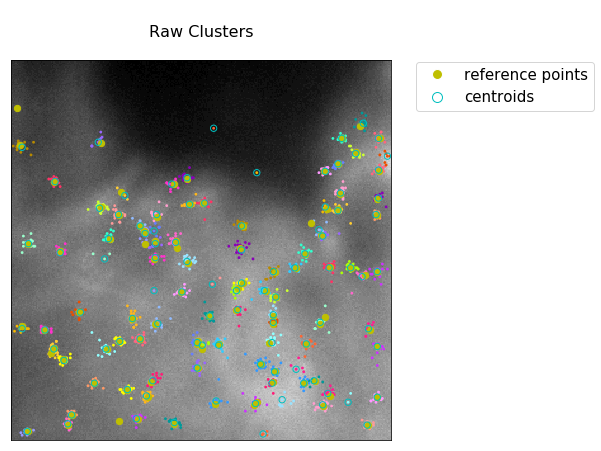

In [4]:
vis.visualize_clusters(clusters=clusters, worker_marker_size=8,
                       cluster_marker_size=40, ref_marker_size=40,
                       csv_filepath=csv_filepath, img_filepath=img_filepath,
                       img_height=img_height, x_bounds=(0, 300),
                       y_bounds=(0, 300), plot_title='\nRaw Clusters\n',
                       show_workers=True, show_centroids=True,
                       show_ref_points=True, bigger_window_size=False)

In [5]:
xs = clusters.centroid_x
ys = clusters.centroid_y
centroids = [[x, y] for x, y in zip(xs, ys)]

centroids_ref = np.asarray(pd.read_csv('./expected_outputs/centroids.csv'))
if (centroids_ref == centroids).all():
    result = 'Pass: found expected cluster centroids'
else:
    result = 'Fail: did not find expected cluster centroids'
print(result)

Pass: found expected cluster centroids


## QC clusters by number of unique annotators

Use `clus.get_clumpiness_threshold()` to find the threshold number of members for a cluster to qualify as "large."

In [6]:
cluster_size_threshold = clus.get_cluster_size_threshold(clusters)

Use `clus.sort_clusters_by_size()` to sort clusters using this threshold.

In [7]:
small_clusters, large_clusters = clus.sort_clusters_by_size(clusters, cluster_size_threshold)

#### Clusters with more members than the cluster size threshold tend to be correct.

In [8]:
correct_list, incorrect_list, total_list, threshold = param.sort_clusters_by_correctness(clusters=clusters, 
                                                                                   correctness_threshold=4, 
                                                                                   csv_filepath=csv_filepath, 
                                                                                   img_height=img_height)

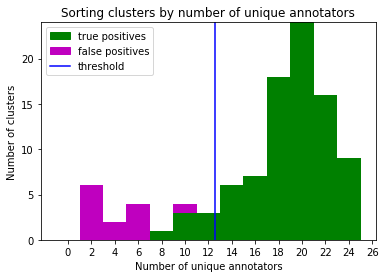

In [9]:
width = 2
plt.figure()
plt.hist([correct_list, incorrect_list], bins = np.arange(0,max(total_list)+width, width)-width/2, stacked = True, color = ['g','m'])
plt.axvline(x=threshold, color='b')
g_patch = mpatches.Patch(color='g', label='true positives')
m_patch = mpatches.Patch(color='m', label='false positives')
kmeans_line = Line2D([0],[0], color='b', label='threshold')
plt.legend(handles=[g_patch, m_patch, kmeans_line])
plt.xlabel("Number of unique annotators")
plt.xticks(np.arange(0,max(total_list)+width, width))
plt.ylabel("Number of clusters")
plt.title('Sorting clusters by number of unique annotators')
plt.show()

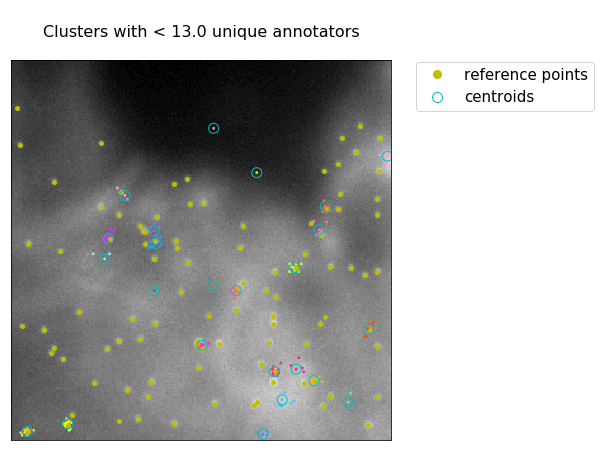

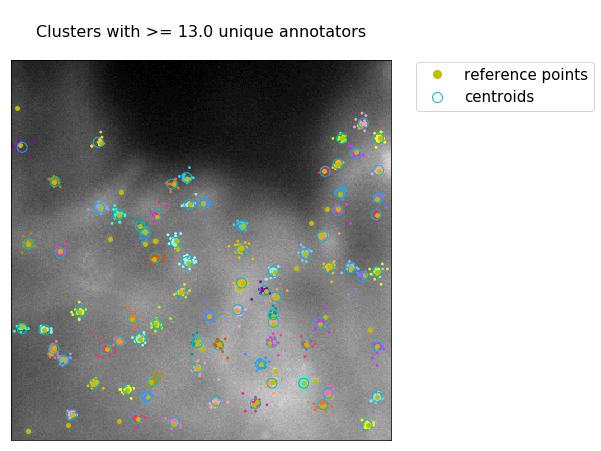

In [10]:
vis.visualize_clusters(clusters=small_clusters, worker_marker_size=8,
                       cluster_marker_size=100, ref_marker_size=15,
                       csv_filepath=csv_filepath, img_filepath=img_filepath,
                       img_height=img_height, x_bounds=(0, 300),
                       y_bounds=(0, 300), plot_title='\nClusters with < %s unique annotators\n' % round(cluster_size_threshold),
                       show_workers=True, show_centroids=True,
                       show_ref_points=True, bigger_window_size=False)

vis.visualize_clusters(clusters=large_clusters, worker_marker_size=8,
                       cluster_marker_size=100, ref_marker_size=15,
                       csv_filepath=csv_filepath, img_filepath=img_filepath,
                       img_height=img_height, x_bounds=(0, 300),
                       y_bounds=(0, 300), plot_title='\nClusters with >= %s unique annotators\n' % round(cluster_size_threshold),
                       show_workers=True, show_centroids=True,
                       show_ref_points=True, bigger_window_size=False)

## QC clusters by clumpiness

Use `clus.get_clumpiness_threshold()` to find the threshold number of annotators who annotate a cluster multiple times.

In [11]:
clumpiness_threshold = clus.get_clumpiness_threshold(large_clusters)

Use `clus.sort_clusters_by_clumpiness()` to sort clusters using this threshold.

In [12]:
clumpy_clusters, nonclumpy_clusters = clus.sort_clusters_by_clumpiness(clusters, clumpiness_threshold)

#### Clusters where many annotators tend to annotate multiple times tend to be clumpy. 

In [13]:
# For each cluster, calc and sort replication of each worker
actual_clumps = []
not_actual_clumps = []
incorrect_clusters = []

for i in range(len(large_clusters.index)):
    row = large_clusters.iloc[[i]]
    members = row.iloc[0]['members']
    workers = []
    x_coords = []
    y_coords = []

    for member in members:
        x_coords.append(member[0])
        y_coords.append(member[1])
        workers.append(member[3])
    
    # Calculate replication of unique workers for each cluster
    unique_workers = np.unique(workers)
    num_instances_list = []
    for unique_worker in unique_workers:
        num_instances_list.append(workers.count(unique_worker))
    singles = num_instances_list.count(1)
    single_fraction = singles/len(unique_workers)

    # Are there at least two ref spots in the area of this cluster? (Is this cluster actually clumpy?)  
    centroid_coord = [row.iloc[0]['centroid_x'], row.iloc[0]['centroid_y']]
    ref_kdt = util.csv_to_kdt(csv_filepath, img_height)
    dist, ind = ref_kdt.query([centroid_coord],k=2)
    index_0 = ind[0][0]
    index_1 = ind[0][1]
    ref_array = np.asarray(ref_kdt.data)
    neighbor_0 = ref_array[index_0]
    neighbor_1 = ref_array[index_1]
    if(dist[0][0] <= 4):
        if ((neighbor_0[0] >= min(x_coords)) and (neighbor_0[0] <= max(x_coords)) and
            (neighbor_0[1] >= min(y_coords)) and (neighbor_0[1] <= max(y_coords)) and 
            (neighbor_1[0] >= min(x_coords)) and (neighbor_1[0] <= max(x_coords)) and
            (neighbor_1[1] >= min(y_coords)) and (neighbor_1[1] <= max(y_coords))):
            actual_clumps.append(single_fraction)
        else:
            not_actual_clumps.append(single_fraction)
    else:
        incorrect_clusters.append(single_fraction)


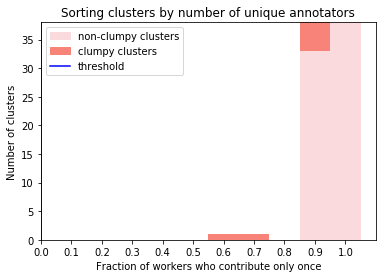

In [14]:
non_clumpy_color = '#fadadd'
clumpy_color = '#f88379'
width = 2
plt.figure()
plt.hist([not_actual_clumps, actual_clumps], bins=np.arange(-0.05,1.25,0.1), stacked=True, color=[non_clumpy_color, clumpy_color])
plt.axvline(x=clumpiness_threshold, color='b')
non_clumpy_patch = mpatches.Patch(color=non_clumpy_color, label='non-clumpy clusters')
clumpy_patch = mpatches.Patch(color=clumpy_color, label='clumpy clusters')
kmeans_line = Line2D([0],[0], color='b', label='threshold')

plt.legend(handles=[non_clumpy_patch, clumpy_patch, kmeans_line])
plt.xticks(np.arange(0,1.1, 0.1))
plt.xlim(0,1.1)
plt.xlabel('Fraction of workers who contribute only once')
plt.ylabel('Number of clusters')
plt.title('Sorting clusters by number of unique annotators')
plt.show()

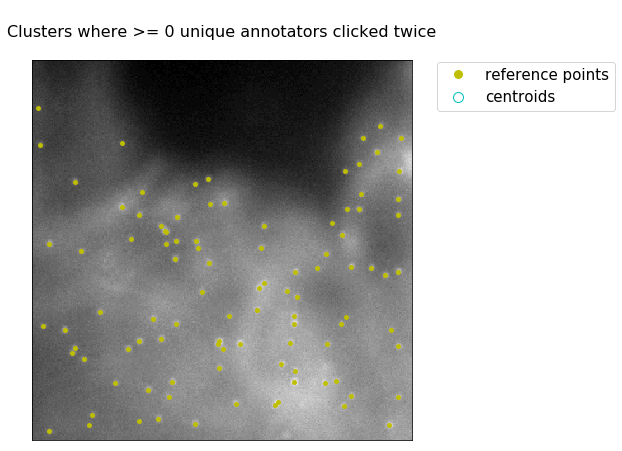

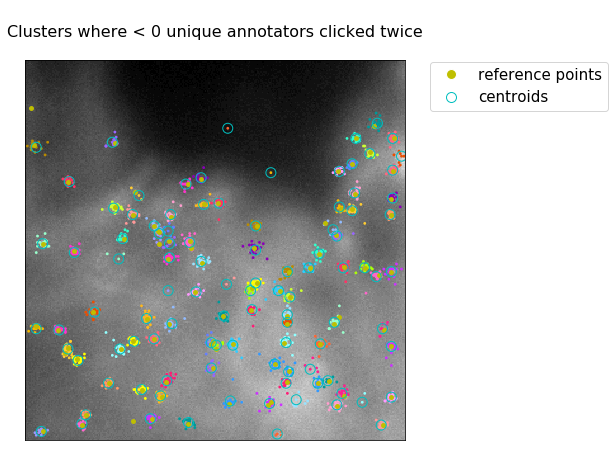

In [16]:
vis.visualize_clusters(clusters=clumpy_clusters, worker_marker_size=8,
                       cluster_marker_size=100, ref_marker_size=15,
                       csv_filepath=csv_filepath, img_filepath=img_filepath,
                       img_height=img_height, x_bounds=(0, 300),
                       y_bounds=(0, 300), plot_title='\nClusters where >= %s unique annotators clicked twice\n' % round(clumpiness_threshold),
                       show_workers=True, show_centroids=True,
                       show_ref_points=True, bigger_window_size=False)

vis.visualize_clusters(clusters=nonclumpy_clusters, worker_marker_size=8,
                       cluster_marker_size=100, ref_marker_size=15,
                       csv_filepath=csv_filepath, img_filepath=img_filepath,
                       img_height=img_height, x_bounds=(0, 300),
                       y_bounds=(0, 300), plot_title='\nClusters where < %s unique annotators clicked twice\n' % round(clumpiness_threshold),
                       show_workers=True, show_centroids=True,
                       show_ref_points=True, bigger_window_size=False)